# Exercise 4
## Time Series Analysis & Recurrent Neural Networks, SoSe 2021
### Author: Elias Olofsson
    Version information:
        2021-05-19: v.1.0. First public release. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.rc('image', cmap='gray')
from pprint import pprint

from sklearn.linear_model import LinearRegression

# Notebook graphics settings: 
%config InlineBackend.figure_format = 'svg'     # inline vector graphics
#%config InlineBackend.figure_format = 'retina' # medium resolution png:s
#plt.rcParams['figure.dpi'] = 120               # custom dpi setting png

## Task 1: Granger Causality

In [2]:
def VAR2(a0, A1, A2, sigma, x0, T):
    """
    Generate a d-variant AR(2) time series.
    """
    x = np.zeros((T, len(x0)))
    eps = np.random.multivariate_normal(np.zeros(2), sigma, size=T)
    x[0] = x0
    x[1] = a0 + A1.dot(x[0]) + eps[0]
    for t in range(2, T):
        x[t] = a0 + A1.dot(x[t-1]) + A2.dot(x[t-2]) + eps[t-1]
    return x

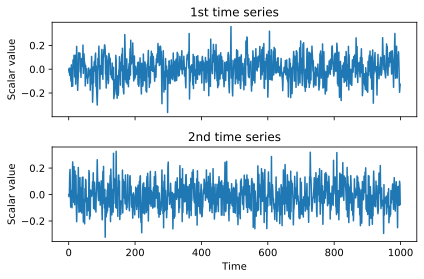

In [3]:
# Create a 2-variant AR(2) time series.
d = 2     # dimensions  
T = 1000  # timesteps
a0 = np.array([0, 0])                   
A1 = np.array([[0.2, 0], [-0.2, 0.1]])  
A2 = np.array([[0.1, 0], [-0.1, 0.1]])
sigma = np.array([[0.01, 0],[0, 0.01]]) # covariance matrix
x0 = np.array([0, 0])                   # initial conditions

x = VAR2(a0, A1, A2, sigma, x0, T)

# Plotting
fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(x[:, 0], label='1st time series')
ax[0].set_title('1st time series')
ax[0].set_ylabel('Scalar value')
#ax[0].legend()

ax[1].plot(x[:, 1], label='2nd time series')
ax[1].set_title('2nd time series')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Scalar value')
#ax[1].legend()
fig.tight_layout()
plt.show()

Since we know the coefficient matrices $A_1$ and $A_2$, I would believe that $x_1$ Granger causes $x_2$, and not the other way around. This is since both  $A_1[0,1] = A_2[0,1] = 0$, while $A_1[1,0] \neq 0$ and  $A_2[0,1] \neq 0$. Thus we have information flowing $x_1 \rightarrow x_2$, but $x_2 \not\rightarrow x_1$, determined by the off-diagonal terms, since

\begin{align}
    x_{1, t} \sim &A_1[0,0] x_{1, t-1} + A_1[0,1] x_{2, t-1} = A_1[0,0] x_{1, t-1}\\
    x_{2, t} \sim &A_1[1,0] x_{1, t-1} + A_1[1,1] x_{2, t-1} = A_1[1,0] x_{1, t-1} + A_1[1,1] x_{2, t-1}
\end{align}

and similarly for $A_2$.

In [4]:
def AR_fit(x, p):
    """
    Estimate the parameters of an Auto-regressive (AR) model 
    of order p on a scalar time series x.
    
    Parameters:
    -----------
    x: np.array shape=(T,)
        Scalar valued time series.
    p: int
        Order of the AR process.

    Returns:
    --------
    coef: np.array shape=(p,)
        Coefficient estimates of the AR(p) model.
    """
    T = len(x)
    y = x[p:] # target vector

    # Regressor matrix
    X = np.zeros((T-p, p+1))    # pre-allocation
    X[:,0] = 1                  # absorbing intercept by a column of ones.
    for i in range(1, p+1):
        X[:,i] = x[p-i:T-i]     # building the regressor matrix

    # Linear regression.
    reg = LinearRegression(fit_intercept=False).fit(X, y)
    AR_coef = reg.coef_
    # AR_coef = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y) # Alternative method
    return AR_coef

def AR_predict(x, AR_coef):
    """
    One-step mean (i.e. without noise) predictions of an AR(p) model 
    on each timestep in time series x.
    """
    T = len(x)
    p = len(AR_coef)-1
    x_hat = np.zeros(T-p)
    for i, t in enumerate(range(p, T)):
        if t >= len(AR_coef):
            x_hat[i] = AR_coef[0] + AR_coef[1:].dot(x[t-1:t-len(AR_coef):-1]) 
        else:
            x_hat[i] = AR_coef[0] + AR_coef[1:].dot(x[t-1::-1])
    return x_hat


def logL(eps, sigma2):
    """
    Compute the log-likelihood of an AR process from the residuals eps and estimated
    variance sigma2. 
    """
    l = len(eps) # T-p
    logL = -0.5*l*np.log(2*np.pi) - 0.5*l*np.log(sigma2) - 0.5*eps.dot(eps)/sigma2
    return logL


def logL_AR(x, p):
    """
    Fit a uni-variate AR(p) model to the time series x, and compute the log-likelihood.
    """
    coef = AR_fit(x, p)             # Fit AR(p) model.
    x_hat = AR_predict(x, coef)     # Get one-step mean predictions.
    eps = x[p:] - x_hat             # Get one-step model residuals.
    sigma2_hat = eps.dot(eps)/(T-p) # Estimate variance of gaussian noise.
    log_L = logL(eps, sigma2_hat)   # Compute the log-likelihood.
    return log_L

In [5]:
# Separate the two time series.
x1 = x[:, 0]
x2 = x[:, 1]

# Fit two uni-variate AR(2) models on each series individually, and compute the log-likelihood on each fit.
p = 2
logL_AR2_x1_reduced = logL_AR(x1, p) # Test if x2 -> x1: Reduced model.
logL_AR2_x2_reduced = logL_AR(x2, p) # Test if x1 -> x2: Reduced model.

print(f'Log-likelihood x1, reduced model: {logL_AR2_x1_reduced:.5}')
print(f'Log-likelihood x2, reduced model: {logL_AR2_x2_reduced:.5}')

Log-likelihood x1, reduced model: 871.73
Log-likelihood x2, reduced model: 838.44


In [6]:
# Fit one VAR(2) model to the dual-variate time series.
from statsmodels.tsa.api import VAR
model = VAR(x)
results = model.fit(maxlags=2)
#results.summary()

# Extracting coefficient matrices A_i and bias a_0.
a0_fit = results.params[0]
A1_fit = results.params[1:3].T
A2_fit = results.params[3:].T

def namestr(obj, namespace):
    # Return the variable names of obj as a string. 
    return [name for name in namespace if namespace[name] is obj]

# Printing the fitted coefficients.
for mat in [a0_fit, A1_fit, A2_fit]:
    print(f"{namestr(mat, globals())[0]} = ")
    pprint(mat)
    print()

a0_fit = 
array([ 0.00193255, -0.0076702 ])

A1_fit = 
array([[ 0.21706389, -0.02043611],
       [-0.20179815,  0.06057381]])

A2_fit = 
array([[ 0.08727186,  0.00103246],
       [-0.05985487,  0.07386756]])



In [7]:
def VAR_predict(x, VAR_coef):
    """
    One-step mean (i.e. without noise) predictions of an VAR(p) model 
    on each timestep in the multi-variate time series x.
    """
    T, D = x.shape
    p = len(VAR_coef)-1
    x_hat = np.zeros((T-p, D))
    for i, t in enumerate(range(p, T)):
        x_hat[i] = VAR_coef[0][0] + np.sum([A.dot(x[t-1-j]) for j, A in enumerate(VAR2_coef[1:])], axis=0)
    return x_hat

In [8]:
# One-step mean prediction of VAR(2) model
VAR2_coef = [a0_fit, A1_fit, A2_fit]
x_hat = VAR_predict(x, VAR2_coef)

# Estimate of the covariance matrix 
sigma2_VAR2_fit = (x[p:] - x_hat).T @ (x[p:] - x_hat) / (T-p)

# One-step residuals of the VAR(2) model.
eps = x[p:] - x_hat

# Compute the log-likelihoods of the full AR models.
logL_AR2_x1_full = logL(eps[:, 0], sigma2_VAR2_fit[0, 0]) # Test if x2 -> x1: Full model.
logL_AR2_x2_full = logL(eps[:, 1], sigma2_VAR2_fit[1, 1]) # Test if x1 -> x2: Full model.

print(f'Log-likelihood x1, full model: {logL_AR2_x1_full:.5}')
print(f'Log-likelihood x2, full model: {logL_AR2_x2_full:.5}')

Log-likelihood x1, full model: 871.95
Log-likelihood x2, full model: 859.32


In [9]:
from scipy.stats import chi2
alpha = 0.05

# ----------- TEST 1 -------------
D1 = 2*(logL_AR2_x1_full - logL_AR2_x1_reduced)    # x2 -> x1 
p_value1 = 1 - chi2.cdf(D1, 2)

if p_value1 <= alpha:
    print(f'x2 does Granger cause x1    : D = {D1:5.3}, p-value = {p_value1:.6}')
else:
    print(f'x2 does not Granger cause x1: D = {D1:5.3}, p-value = {p_value1:.6}')

# ----------- TEST 2 -------------
D2 = 2*(logL_AR2_x2_full - logL_AR2_x2_reduced)    # x1 -> x2 
p_value2 = 1 - chi2.cdf(D2, 2)

if p_value2 <= alpha:
    print(f'x1 does Granger cause x2    : D = {D2:5.3}, p-value = {p_value2:.6}')
else:
    print(f'x1 does not Granger cause x2: D = {D2:5.3}, p-value = {p_value2:.6}')

x2 does not Granger cause x1: D = 0.427, p-value = 0.807631
x1 does Granger cause x2    : D =  41.8, p-value = 8.56443e-10


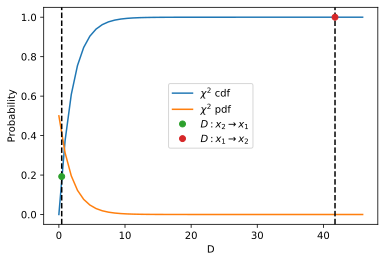

In [10]:
D_range = np.linspace(0, max(D1, D2) * 1.1)
plt.plot(D_range, chi2.cdf(D_range, 2), label=r'$\chi^2$ cdf')
plt.plot(D_range, chi2.pdf(D_range, 2), label=r'$\chi^2$ pdf')
plt.axvline(x=D1, c='k', ls='--')
plt.axvline(x=D2, c='k', ls='--')
plt.plot(D1, chi2.cdf(D1, 2), 'o', label=r'$D: x_2 \rightarrow x_1$')
plt.plot(D2, chi2.cdf(D2, 2), 'o', label=r'$D: x_1 \rightarrow x_2$')
plt.xlabel('D')
plt.ylabel('Probability')
plt.legend()
plt.show()

## Task 2: M-step in a linear Gaussian state space model

Please see the second attached file "exercise4_task2.pdf" for my hand-written solution.